In [46]:
from utils.util import read_dataset

train_data = read_dataset(dirpath="./datasets/it-trajs_complete/train", interpolate=True, normalize=True)

In [47]:
all_label_zeros = []
all_label_ones = []
all_label_twos = []
all_label_threes = []


for filename, dic in train_data.items():
    if filename[0] == '0':
        all_label_zeros.append(dic)
    if filename[0] == '1':
        all_label_ones.append(dic)
    if filename[0] == '2':
        all_label_twos.append(dic)
    if filename[0] == '3':
        all_label_threes.append(dic)


<Axes: xlabel='x'>

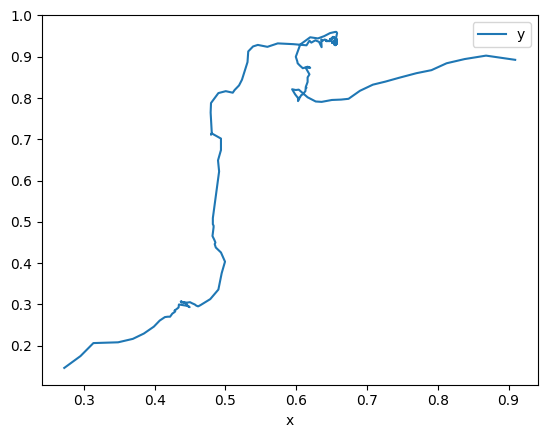

In [48]:
all_label_ones[0]
all_label_ones[0]['dataframe'].plot(x='x', y='y')


In [61]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM

def extract_feats(df):
    """
    Extract (step-length, cos(turn-angle), sin(turn-angle)) features
    from a trajectory DataFrame with columns ['x','y'].
    """
    coords = df[['x','y']].values
    if len(coords) < 2:
        return np.empty((0, 3))
    deltas = np.diff(coords, axis=0)
    # step lengths
    r = np.linalg.norm(deltas, axis=1)
    # headings
    phi = np.arctan2(deltas[:,1], deltas[:,0])
    # turning angles
    theta = np.diff(phi, prepend=phi[0])
    # return r, cos(theta), sin(theta)
    return np.column_stack([r, np.cos(theta), np.sin(theta)])

def train_hmm(all_label_ones, n_components=3, cov_type='full', n_iter=1000):
    """
    Train a Gaussian HMM on the minority-class trajectories,
    using (r, cosθ, sinθ) features.
    
    Parameters:
      all_label_ones: list of dicts with key 'dataframe' (pd.DataFrame with 'x','y')
      n_components: number of hidden states
      cov_type: covariance type for Gaussian emissions
      n_iter: max iterations for fitting
    """
    sequences, lengths = [], []
    for entry in all_label_ones:
        feats = extract_feats(entry['dataframe'])
        if len(feats) > 0:
            sequences.append(feats)
            lengths.append(len(feats))
    X = np.vstack(sequences)
    model = GaussianHMM(n_components=n_components,
                        covariance_type=cov_type,
                        n_iter=n_iter,
                        random_state=42)
    model.fit(X, lengths)
    return model

def generate_synthetic_trajectories(model, all_label_ones, n_samples=50):
    """
    Sample synthetic trajectories from the trained HMM.
    
    Each sample:
      - picks a random length from the real data
      - samples that many steps in (r,cosθ,sinθ) space
      - reconstructs Δx,Δy from (r,θ), accumulates to positions
      - uses a random real start point and random initial heading
    """
    synthetic = []
    # list of original trajectory lengths (in frames)
    orig_lengths = [len(e['dataframe']) for e in all_label_ones if len(e['dataframe']) > 1]
    
    for _ in range(n_samples):
        # pick a real length, convert to number of steps
        L = np.random.choice(orig_lengths)
        n_steps = max(L - 1, 1)
        
        # sample features: (r, cosθ, sinθ)
        feats, _ = model.sample(n_steps)
        r_s, cos_s, sin_s = feats.T
        θ_s = np.arctan2(sin_s, cos_s)
        
        # reconstruct Δx, Δy
        phi0 = np.random.uniform(-np.pi, np.pi)
        cum_phi = phi0 + np.cumsum(θ_s)
        deltas = np.column_stack([r_s * np.cos(cum_phi),
                                  r_s * np.sin(cum_phi)])
        
        # pick a random real starting point
        start_df = np.random.choice(all_label_ones)['dataframe']
        start_pt = start_df[['x','y']].iloc[0].values
        
        # accumulate to get absolute positions
        coords = np.vstack([start_pt, start_pt + np.cumsum(deltas, axis=0)])
        
        # build synthetic DataFrame
        frames = np.arange(len(coords))
        df_syn = pd.DataFrame({
            'frame': frames,
            'x': coords[:,0],
            'y': coords[:,1]
        })
        synthetic.append(df_syn)
    
    return synthetic

import matplotlib.pyplot as plt

def plot_real_vs_synthetic(real_df, synthetic_df):
    """
    Plot one real trajectory and one synthetic trajectory
    with a clean, publication-quality style.
    """
    # Use serif fonts for a thesis-style look
    plt.rcParams.update({
        'font.family': 'serif',
        'font.size': 12,
        'axes.labelsize': 12,
        'axes.titlesize': 14,
        'legend.fontsize': 10,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'figure.dpi': 300
    })

    fig, ax = plt.subplots(figsize=(3, 6))
    ax.plot(
        real_df['x'], real_df['y'],
        linestyle='-',
        linewidth=1.5,
        label='Real',
        color='black'
    )
    ax.plot(
        synthetic_df['x'], synthetic_df['y'],
        linestyle='--',
        linewidth=1.5,
        label='Synthetic',
        color='dimgray'
    )

    ax.set_xlabel('X position (normalized)')
    ax.set_ylabel('Y position (normalized)')
    ax.set_title('Real vs. Synthetic Trajectory')
    ax.grid(which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.set_aspect('equal', adjustable='box')
    ax.legend(frameon=False)
    plt.tight_layout()
    plt.show()



In [50]:

model_zero = train_hmm(all_label_zeros, n_components=3)
model_one = train_hmm(all_label_ones, n_components=3)
model_two = train_hmm(all_label_twos, n_components=3)
model_three = train_hmm(all_label_threes, n_components=3)


Model is not converging.  Current: 2536414.3581040213 is not greater than 2646348.5105123217. Delta is -109934.15240830043
Model is not converging.  Current: 181844.77873531627 is not greater than 239667.50745397503. Delta is -57822.728718658764
Model is not converging.  Current: 113245.80295280537 is not greater than 206517.7124348328. Delta is -93271.90948202742


In [51]:
len_zero = len(all_label_zeros)
len_one = len(all_label_ones)
len_two = len(all_label_twos)
len_three = len(all_label_threes)
print(f"{len_zero}, {len_one} {len_two}, {len_three}")

1109, 53 59, 162


In [52]:
synthetic_trajs_zero = generate_synthetic_trajectories(model_zero, all_label_zeros, n_samples=0)
synthetic_trajs_one = generate_synthetic_trajectories(model_one, all_label_ones, n_samples=106)
synthetic_trajs_two = generate_synthetic_trajectories(model_two, all_label_twos, n_samples=118)
synthetic_trajs_three = generate_synthetic_trajectories(model_three, all_label_threes, n_samples=324)

In [53]:
def save_trajectories_to_dir(trajectories, output_dir, prefix='traj'):
    """
    Save each trajectory DataFrame to CSV, renaming columns to
      'nframe', 'x0', 'y0' for downstream compatibility,
    and un-normalizing x and y by the frame dimensions.
    """
    os.makedirs(output_dir, exist_ok=True)
    for idx, df in enumerate(trajectories, start=1):
        # un-normalize coordinates
        df_un = df.copy()
        df_un['x'] = df_un['x'] * 1920
        df_un['y'] = df_un['y'] * 1080

        # rename columns
        df_to_save = df_un.rename(columns={
            'frame': 'nframe',
            'x': 'x0',
            'y': 'y0'
        })

        path = os.path.join(output_dir, f"{prefix}_{idx}.csv")
        df_to_save.to_csv(path, index=False)

In [54]:
synthetic_trajs_two

[     frame         x         y
 0        0  0.494792  0.668519
 1        1  0.477193  0.664371
 2        2  0.481923  0.668161
 3        3  0.559969  0.668228
 4        4  0.552745  0.659924
 ..     ...       ...       ...
 141    141  0.523135  0.874512
 142    142  0.524320  0.873388
 143    143  0.524257  0.873448
 144    144  0.523248  0.872151
 145    145  0.514726  0.866976
 
 [146 rows x 3 columns],
      frame         x         y
 0        0  0.612500  0.896296
 1        1  0.594422  0.895981
 2        2  0.599849  0.898679
 3        3  0.676129  0.882172
 4        4  0.667307  0.875591
 ..     ...       ...       ...
 155    155  0.715776  1.112729
 156    156  0.717310  1.112002
 157    157  0.717983  1.112319
 158    158  0.717655  1.113436
 159    159  0.717351  1.114475
 
 [160 rows x 3 columns],
     frame         x         y
 0       0  0.385417  0.498148
 1       1  0.371292  0.486860
 2       2  0.373943  0.492311
 3       3  0.444431  0.525814
 4       4  0.441463  0

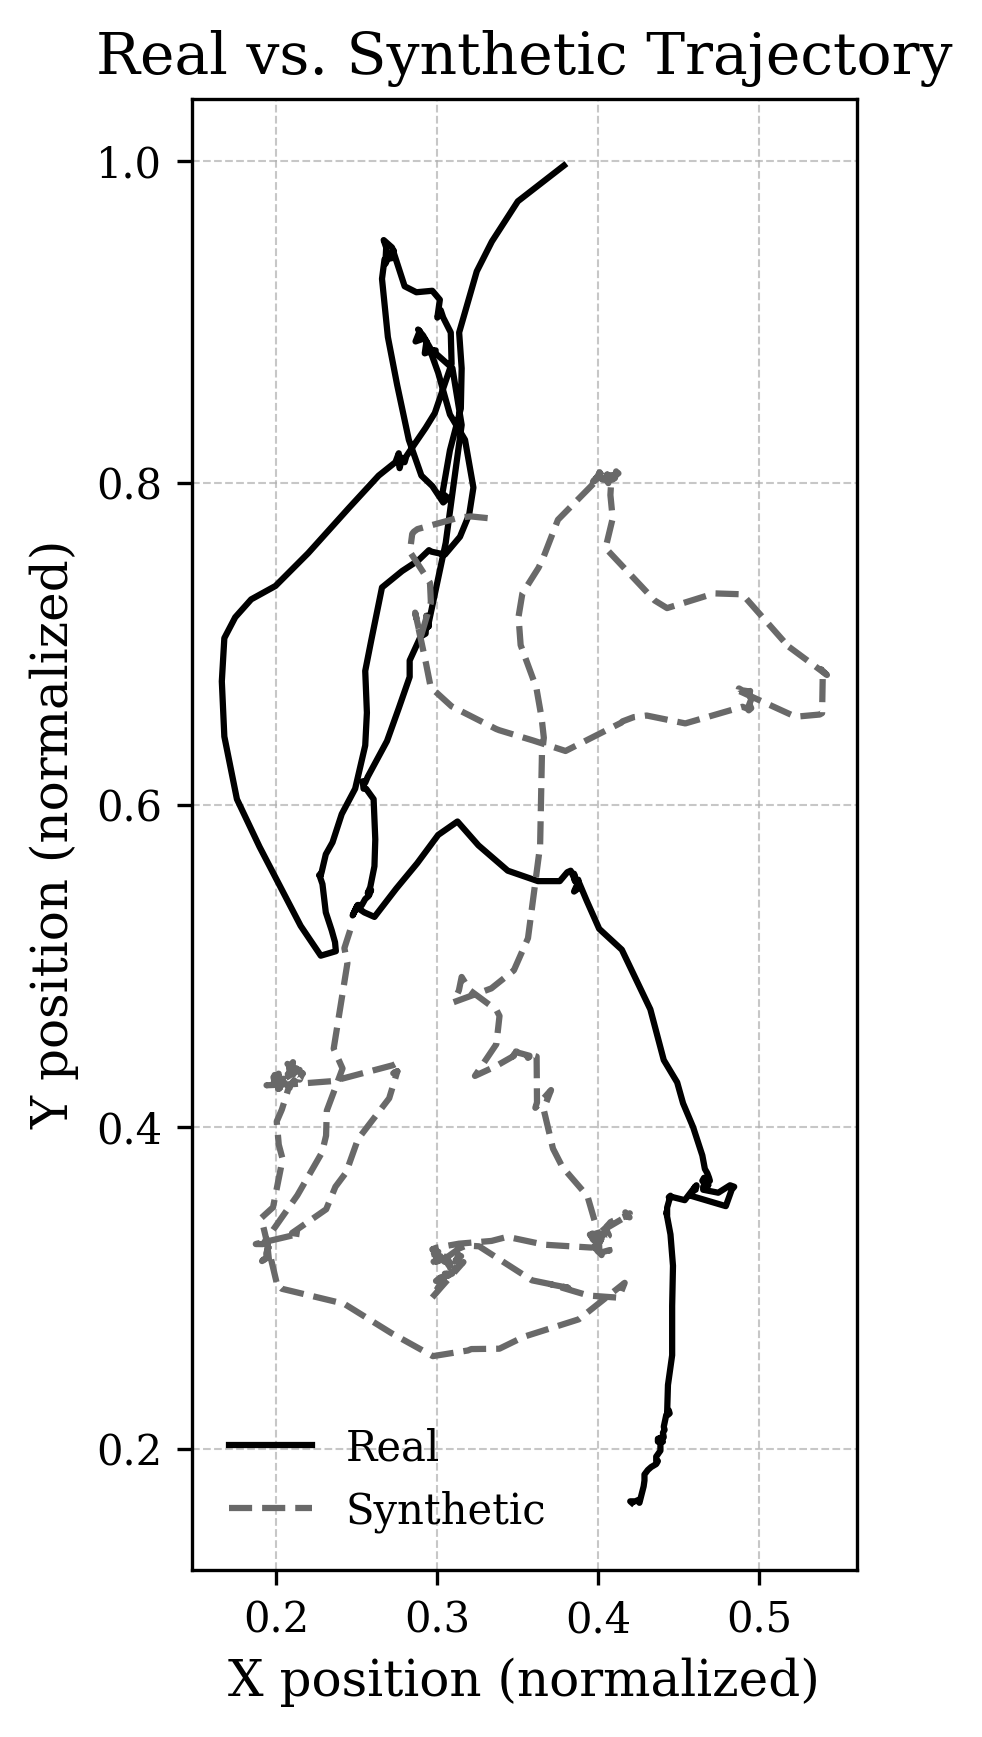

In [62]:
plot_real_vs_synthetic(all_label_ones[11]['dataframe'], synthetic_trajs_one[20])

In [57]:
#save_trajectories_to_dir(synthetic_trajs_zero, "datasets/it-trajs_complete_hmm/train", "0")

save_trajectories_to_dir(synthetic_trajs_one, "datasets/it-trajs_complete_hmm/train", "1")
save_trajectories_to_dir(synthetic_trajs_two, "datasets/it-trajs_complete_hmm/train", "2")
save_trajectories_to_dir(synthetic_trajs_three, "datasets/it-trajs_complete_hmm/train", "3")


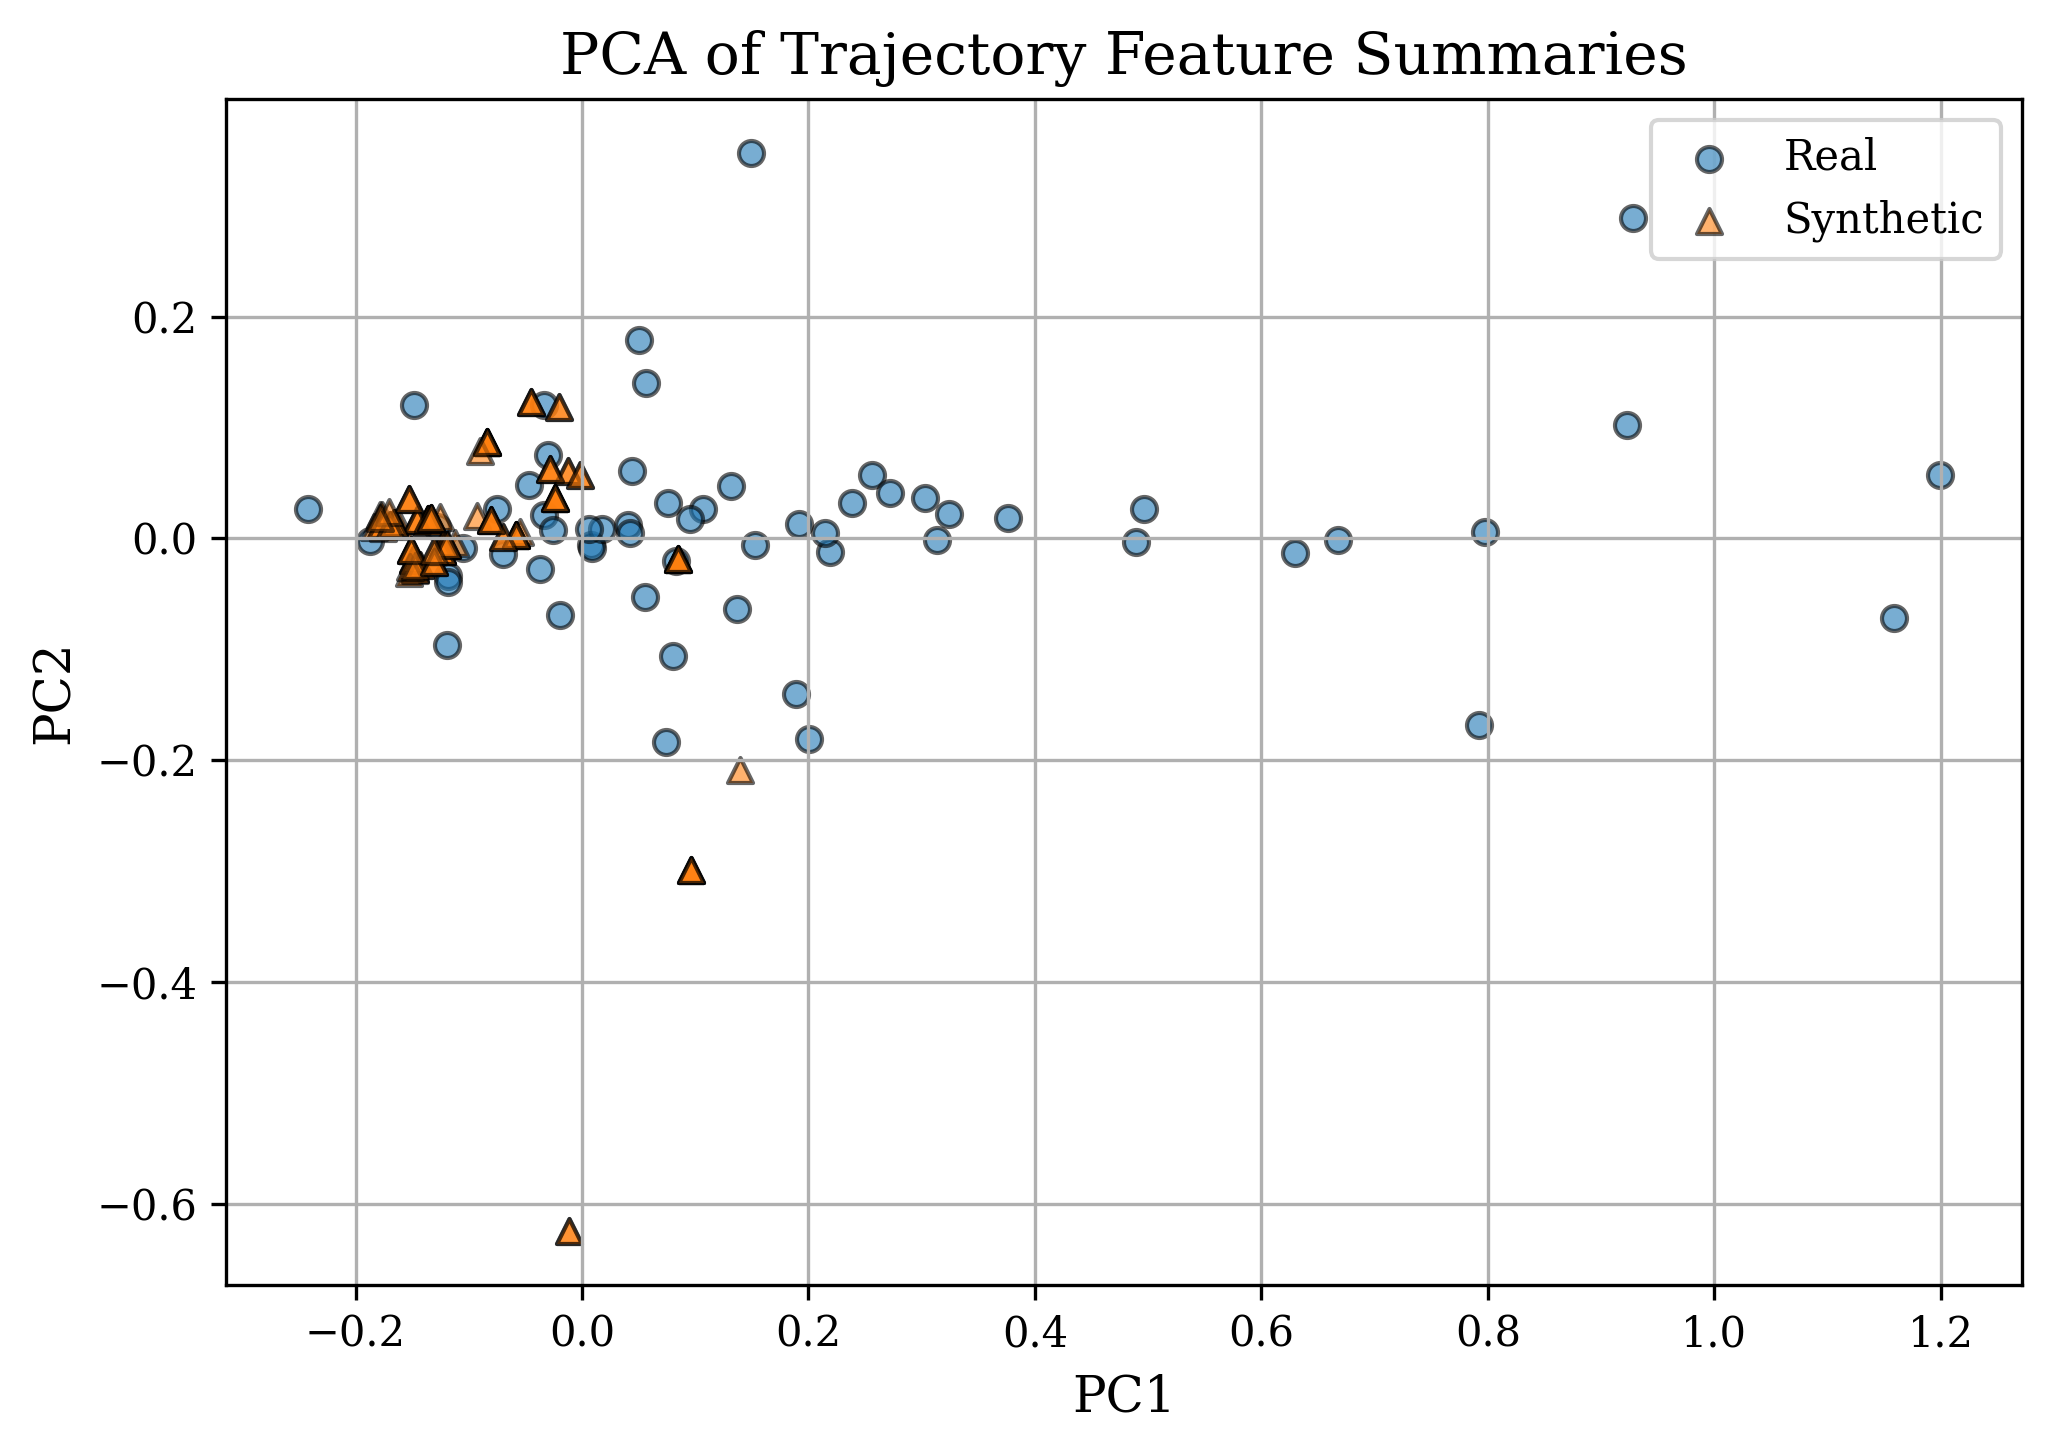

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# make sure you have extract_feats(df) available from your pipeline

def summarize_trajectory(df):
    """
    Given a DataFrame with columns ['x','y'], extract (r, cosθ, sinθ)
    per step and return a 6-dim vector: [mean_r, mean_cos, mean_sin, std_r, std_cos, std_sin].
    """
    feats = extract_feats(df)                  # shape (T-1, 3)
    return np.hstack([feats.mean(axis=0), 
                      feats.std(axis=0)])

# 1) build summary arrays for real and synthetic
real_summaries = np.array([
    summarize_trajectory(entry['dataframe'])
    for entry in all_label_twos
    if len(entry['dataframe']) >= 2
])

synthetic_summaries = np.array([
    summarize_trajectory(df)
    for df in synthetic_trajs_two
])

# 2) stack together and create labels
X = np.vstack([real_summaries, synthetic_summaries])
y = np.array([0]*len(real_summaries) + [1]*len(synthetic_summaries))  # 0=real, 1=synthetic

# 3) run PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# 4) plot
plt.figure(figsize=(7,5))
plt.scatter(X_pca[y==0, 0], X_pca[y==0, 1],
            alpha=0.6, label='Real', edgecolor='k')
plt.scatter(X_pca[y==1, 0], X_pca[y==1, 1],
            alpha=0.6, label='Synthetic', edgecolor='k', marker='^')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Trajectory Feature Summaries')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
